# Initialization

In [ ]:
%load_ext google.colab.data_table

import os
import json
import gzip
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen

from google.colab import files
from IPython.display import clear_output

clear_output()
print('Done!')

Done!


In [ ]:
! git clone https://github.com/zygmuntz/goodbooks-10k
! mv /content/goodbooks-10k/ratings.csv /content
! mv /content/goodbooks-10k/to_read.csv /content
! mv /content/goodbooks-10k/books.csv /content
! mv /content/goodbooks-10k/tags.csv /content
! mv /content/goodbooks-10k/book_tags.csv /content
clear_output()
print('Done!')

Done!


# Data Cleaning

In [ ]:
books = pd.read_csv('books.csv', error_bad_lines=False).dropna()
tags  = pd.read_csv('tags.csv', error_bad_lines=False).dropna()
bt    = pd.read_csv('book_tags.csv', error_bad_lines=False).dropna()
clear_output()
print('Done!')

Done!


In [ ]:
books.ratings_count.mean()

61174.830534351146

In [ ]:
books.head(5)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
tags.loc[5000:5005]

,tag_id,tag_name
5000,5000,book-movie
5001,5001,book-movie-guide
5002,5002,book-of-ember
5003,5003,book-of-mormon
5004,5004,book-of-the-art
5005,5005,book-of-the-month


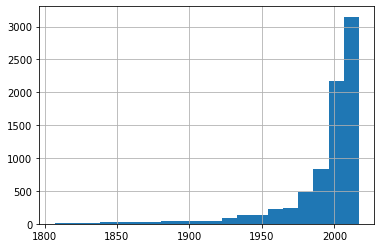

In [ ]:
plt.figure()

df = books[books.original_publication_year > 1800].original_publication_year
df.hist(bins=20)

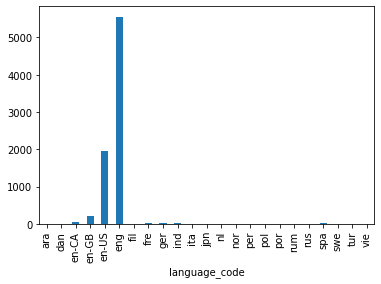

In [ ]:
plt.figure()

df = books.groupby('language_code').count().goodreads_book_id
df.plot(kind='bar')

In [ ]:
# @title Drop Columns
books = books[['goodreads_book_id', 'authors', 'original_publication_year', 'original_title', 'language_code', 'average_rating', 'ratings_count']]

In [ ]:
# @title Join Tables
bt = bt.merge(tags, on='tag_id')
books = books.merge(bt[['goodreads_book_id', 'tag_name']], on='goodreads_book_id')

In [ ]:
books.head()

,goodreads_book_id,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,tag_name
0,2767052,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,to-read
1,2767052,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,fantasy
2,2767052,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,favorites
3,2767052,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,currently-reading
4,2767052,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,young-adult


# Recommender System

In [ ]:
def recommend(tag, from_year, to_year, language, percentile=0.8):
  df = books.copy()

  if len(tag) > 0:
    df = df[df.tag_name == tag]

  if len(language) > 0:
    df = df[df.language_code.isin(language)]

  df = df[(df['original_publication_year'] >= from_year) & 
          (df['original_publication_year'] <= to_year)]

  if len(df) == 0:
    return

  C = df['average_rating'].mean()
  m = df['ratings_count'].quantile(percentile)

  qdf = df.copy().loc[df['ratings_count'] >= m]
  qdf['score'] = qdf.apply(lambda x: (x['ratings_count']/(x['ratings_count']+m) * x['average_rating']) 
                                    + (m/(m+x['ratings_count']) * C)
                                    ,axis=1)
  
  return qdf.sort_values('score', ascending=False)


In [ ]:
#@title Try Recommender System
tag = "horror" #@param {type:"string"}
from_year =  1998#@param {type:"integer"}
to_year = 2017 #@param {type:"integer"}
language = "English" #@param ["All", "English","Spanish","French","Dutch","Italian","Farsi","Swedish","Turkish","Portuguese","German","Arabic","Norwegian","Japanese","Russian"]
percentile = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
list_size =  5#@param {type:"integer"}
lang2code = {
    "All":  [],
    "English": ['eng', 'en-US', 'en-CA', 'en-GB'],
    "Spanish": ['spa'],
    "French":  ['fre'],
    "Dutch":   ['nl'],
    "Italian": ['ita'],
    "Farsi":   ['per'],
    "Swedish": ['swe'],
    "Turkish": ['tur'],
    "Portuguese": ['por'],
    "German":  ['ger'],
    "Arabic": ['ara'],
    "Norwegian": ['nor'],
    "Japanese": ['jpn'],
    "Russian": ['rus'],
}
recommend(tag, from_year, to_year, lang2code[language], percentile).head(list_size)

,goodreads_book_id,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,tag_name,score
146773,6585201,Jim Butcher,2010.0,Changes,eng,4.54,66402,horror,4.395096
150870,12216302,Jim Butcher,2012.0,Cold Days,en-US,4.51,57779,horror,4.358608
55242,13615,"Tsugumi Ohba, Takeshi Obata",2004.0,デスノート #1 (Desu Nōto) Taikutsu (退屈),eng,4.42,139501,horror,4.357488
188168,19486421,Jim Butcher,2014.0,Skin Game,eng,4.55,41512,horror,4.346357
123973,17683,Jim Butcher,2005.0,Dead Beat,eng,4.43,78123,horror,4.327559
